# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


### Some code blocks are taken from previous assignments. And some used the code present in original file ('3_DonorsChoose_KNN.ipynb') which is mentioned in comments.

In [8]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import dill
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [9]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

**Taking only 50K points as KNN Classifier runs lot slower with many points**

In [10]:
import random
project_data = project_data.loc[random.sample(list(project_data.index), 50000)]

In [11]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [12]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [13]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [14]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [15]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [16]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [17]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   
76127     SpecialNeeds                        SpecialNeeds   

                                                   essay  
55660  I have been fortunate enough to use the Fairy ...  
76127  Imagine being 8-9 years old. You're in your th...

In [18]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [19]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)

I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, si

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

The great essayist James Baldwin once said, \"Children have never been very good at listening to their elders, but they have never failed to imitate them\". My Kinders are truly amazing. They are full of energy and have an excessive thirst for learning. My kindergarten class is the very first school or classroom experience that they have ever had.\r\n\r\nOur school is one of the lowest performing schools in the city and is located in a high poverty area. These facts do not deter my students from wanting to achieve. They deserve to have access to resources that will enhance their curiosity as learners. My students are committed, energetic and resilient.\r\n\r\nThank youNurturing individual learning styles are essential to a motivated kindergarten class. These materials will help my students by  making our learning environment inviting while directly nurturing different learning styles. I want to cater to individual learning styles and needs. My bright eyed kindergarteners need to be mot

In [22]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

The great essayist James Baldwin once said,  Children have never been very good at listening to their elders, but they have never failed to imitate them . My Kinders are truly amazing. They are full of energy and have an excessive thirst for learning. My kindergarten class is the very first school or classroom experience that they have ever had.    Our school is one of the lowest performing schools in the city and is located in a high poverty area. These facts do not deter my students from wanting to achieve. They deserve to have access to resources that will enhance their curiosity as learners. My students are committed, energetic and resilient.    Thank youNurturing individual learning styles are essential to a motivated kindergarten class. These materials will help my students by  making our learning environment inviting while directly nurturing different learning styles. I want to cater to individual learning styles and needs. My bright eyed kindergarteners need to be motivated and

In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

The great essayist James Baldwin once said Children have never been very good at listening to their elders but they have never failed to imitate them My Kinders are truly amazing They are full of energy and have an excessive thirst for learning My kindergarten class is the very first school or classroom experience that they have ever had Our school is one of the lowest performing schools in the city and is located in a high poverty area These facts do not deter my students from wanting to achieve They deserve to have access to resources that will enhance their curiosity as learners My students are committed energetic and resilient Thank youNurturing individual learning styles are essential to a motivated kindergarten class These materials will help my students by making our learning environment inviting while directly nurturing different learning styles I want to cater to individual learning styles and needs My bright eyed kindergarteners need to be motivated and engaged in the learnin

In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "nan", "nannan"]

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:40<00:00, 1231.10it/s]


In [26]:
# after preprocesing
preprocessed_essays[20000]

'great essayist james baldwin said children never good listening elders never failed imitate kinders truly amazing full energy excessive thirst learning kindergarten class first school classroom experience ever school one lowest performing schools city located high poverty area facts not deter students wanting achieve deserve access resources enhance curiosity learners students committed energetic resilient thank younurturing individual learning styles essential motivated kindergarten class materials help students making learning environment inviting directly nurturing different learning styles want cater individual learning styles needs bright eyed kindergarteners need motivated engaged learning process tools perfect assets needed order foster rigorous engaging classroom environment part city needed school resources extremely limited students materials create environment keep attention learner'

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [27]:
# similarly you can preprocess the titles also

### Following Code blocks provided by me.

In [28]:
# Code took from original code provided.
# Also function used from original code.
preprocessed_titles = []

for sent in tqdm(project_data['project_title'].values):
    sent = decontracted(sent)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 26909.93it/s]


In [29]:
preprocessed_titles[20000]

'flexible seating essentials'

### Following Code blocks present in original notebook.

## 1.5 Preparing data for models

In [30]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.5.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [31]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
categories_one_hot = vectorizer.fit_transform(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (50000, 9)


In [32]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
sub_categories_one_hot = vectorizer.fit_transform(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'PerformingArts', 'SocialSciences', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (50000, 30)


In [33]:
# Please do the similar feature encoding with state, teacher_prefix and project_grade_category also

### Following Code blocks provided by me.

In [34]:
# Code took from original code provided.
states = project_data['school_state'].unique()
vectorizer = CountVectorizer(vocabulary=list(states), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encoding", school_state_one_hot.shape)

['CA', 'UT', 'GA', 'WA', 'OH', 'SC', 'FL', 'MI', 'NY', 'MD', 'MS', 'AZ', 'OK', 'PA', 'NC', 'CO', 'DC', 'MA', 'IL', 'AL', 'TX', 'TN', 'IN', 'NJ', 'CT', 'AR', 'MO', 'VA', 'WV', 'LA', 'SD', 'ID', 'IA', 'MN', 'WI', 'NM', 'KY', 'OR', 'NV', 'RI', 'KS', 'WY', 'HI', 'NH', 'NE', 'AK', 'ME', 'DE', 'ND', 'MT', 'VT']
Shape of matrix after one hot encoding (50000, 51)


There are some NaN's in teacher_prefix column. replacing them with 'Mrs.' as that has high occurance in that column.

In [35]:
print("Number of NaN's before replacement in column: ", sum(project_data['teacher_prefix'].isna()))
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.nan, 'Mrs.', regex=True)
print("Number of NaN's after replacement in column: ", sum(project_data['teacher_prefix'].isna()))

# Output may show both zeros as I re-run this several times. But there are 3 zeros in original column.

Number of NaN's before replacement in column:  1
Number of NaN's after replacement in column:  0


In [36]:
# Code took from original code provided.
prefixes = project_data['teacher_prefix'].unique()
vectorizer = CountVectorizer(vocabulary=list(prefixes), lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values)
print("Shape of matrix after one hot encoding", teacher_prefix_one_hot.shape)

['Mrs.', 'Ms.', 'Mr.', 'Teacher', 'Dr.']
Shape of matrix after one hot encoding (50000, 5)


In [37]:
grades = project_data['project_grade_category'].unique()
vectorizer = CountVectorizer(vocabulary=list(grades), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())

project_grade_category_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encoding", project_grade_category_one_hot.shape)

['Grades PreK-2', 'Grades 3-5', 'Grades 9-12', 'Grades 6-8']
Shape of matrix after one hot encoding (50000, 4)


### Following Code blocks present in original notebook.

### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

In [38]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=15)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (50000, 10232)


In [39]:
# you can vectorize the title also 
# before you vectorize the title make sure you preprocess it

### Following Code blocks provided by me.

In [40]:
# Code took from original code provided.
# We are considering only the words which appeared in at least 5 documents(rows or projects).
# Reduced number as title has less words
vectorizer = CountVectorizer(min_df=10)
titles_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ", titles_bow.shape)

Shape of matrix after one hot encodig  (50000, 1994)


### Following Code blocks present in original notebook.

#### 1.5.2.2 TFIDF vectorizer

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=15)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (50000, 10232)


#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [42]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [43]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [44]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:18<00:00, 2726.23it/s]


50000
300


#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [46]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:46<00:00, 174.56it/s]


50000
300


In [47]:
# Similarly you can vectorize for title also

### Following Code blocks provided by me.

In [48]:
# Code took from original code provided.
# tfidf of project titles
vectorizer = TfidfVectorizer(min_df=10)
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_tfidf.shape)

Shape of matrix after one hot encodig  (50000, 1994)


In [49]:
# Code took from original code provided.
# avg-w2v for project titles
avg_w2v_titles = []
for sentence in tqdm(preprocessed_titles):
    vector = np.zeros(300)
    cnt_words =0;
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_titles.append(vector)

print(len(avg_w2v_titles))
print(len(avg_w2v_titles[0]))

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 20348.19it/s]


50000
300


In [50]:
# Code took from original code provided.
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [51]:
# Code took from original code provided.
# tfidf-w2v for project titles
tfidf_w2v_titles = []
for sentence in tqdm(preprocessed_titles):
    vector = np.zeros(300)
    tf_idf_weight =0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_titles.append(vector)

print(len(tfidf_w2v_titles))
print(len(tfidf_w2v_titles[0]))

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:10<00:00, 4616.35it/s]


50000
300


### Following Code blocks present in original notebook.

### 1.5.3 Vectorizing Numerical features

In [52]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [53]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.2917768, Standard deviation : 364.8587347086088


In [54]:
price_standardized

array([[ 1.1696533 ],
       [-0.23368435],
       [ 0.50087392],
       ...,
       [-0.42463497],
       [-0.08146105],
       [ 0.27601977]])

### Following Code blocks provided by me.

In [55]:
warnings.filterwarnings("ignore")
# Code took from original code provided
scalar = StandardScaler()
scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
print(f"Mean : {scalar.mean_[0]}, Standard deviation : {np.sqrt(scalar.var_[0])}")

# Now standardize the data with above maen and variance.
previously_posted_projects_standardized = \
                scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
print(previously_posted_projects_standardized)

Mean : 11.15184, Standard deviation : 27.576510015127006
[[ 1.51752923]
 [-0.25934536]
 [-0.33187086]
 ...
 [-0.22308262]
 [-0.29560811]
 [-0.40439635]]


### Following Code blocks present in original notebook.

### 1.5.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [56]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

(50000, 9)
(50000, 30)
(50000, 10232)
(50000, 1)


In [57]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(50000, 10272)

# Assignment 3: Apply KNN

<ol>
    <li><strong>[Task-1] Apply KNN(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_essay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_essay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning to find best K</strong>
        <ul>
    <li>Find the best hyper parameter which results in the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation (or) simple cross validation data</li>
    <li>Use gridsearch-cv or randomsearch-cv or  write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, as shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once you find the best hyper parameter, you need to train your model-M using the best hyper-param. Now, find the AUC on test data and plot the ROC curve on both train and test using model-M.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <li><strong> [Task-2] </strong>
        <ul>
            <li>Select top 2000 features from feature <font color='red'>Set 2</font> using <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html'>`SelectKBest`</a>
and then apply KNN on top of these features</li>
            <li>
                <pre>
                from sklearn.datasets import load_digits
                from sklearn.feature_selection import SelectKBest, chi2
                X, y = load_digits(return_X_y=True)
                X.shape
                X_new = SelectKBest(chi2, k=20).fit_transform(X, y)
                X_new.shape
                ========
                output:
                (1797, 64)
                (1797, 20)
                </pre>
            </li>
            <li>Repeat the steps 2 and 3 on the data matrix after feature selection</li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. K Nearest Neighbor</h1>

### Some code blocks are taken from previous assignments. And some used the code present in original file ('3_DonorsChoose_KNN.ipynb') which is mentioned in comments.

### Following Code blocks provided by me.

**Adding a column `summary_numeric_bool` instead of `project_resource_summary` column which tells if resource summary has a number in it**

In [58]:
# ref: https://stackoverflow.com/questions/4138202/using-isdigit-for-floats
def nums_in_str(text):
    """
    Returns list of numbers present in the given string. Numbers := floats ints etc.
    """
    result = []
    for s in text.split():
        try:
            x = float(s)
            result.append(x)
        except:
            continue
    return result

In [59]:
print(nums_in_str('HE44LLo 56 are -89 I 820.353 in -78.39 what .293 about 00'))

[56.0, -89.0, 820.353, -78.39, 0.293, 0.0]


In [60]:
numbers_in_summary = np.array([len(nums_in_str(s)) for s in project_data['project_resource_summary']])
project_data['summary_numeric_bool'] = list(map(int, numbers_in_summary>0))

### Taking Relevant columns as X (input data to model) and y (output class label)

In [61]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'summary_numeric_bool'],
      dtype='object')

In [62]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   
1           UT 2016-04-27 00:31:25             Grades 3-5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2          ...           \
0  My students come from a variety of backgrounds...          ...            
1  Most of my students have autism, anxiety, anot...          ...            

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                           53                    1   
1                                            4                    1   

   clean_categories                 clean_subcategories  \
0      Math_Science  AppliedSciences Health_LifeScience   
1      SpecialNeeds                        SpecialNeeds   

                                               essay   price  quantity  \
0  I have been fortunate enough to use the Fairy ...  725.05         4   
1  Imagine being 8-9 years old. You're in your th...  213.03         8   

   summary_numeric_bool  
0                     0  
1                     0  

[2 rows x 21 columns]

In [63]:
# Categorical and numerical columns are listed below.
X_columns = ['teacher_prefix', 'school_state', 'project_grade_category', 'summary_numeric_bool',\
             'teacher_number_of_previously_posted_projects', 'clean_categories', 'clean_subcategories',\
             'price', 'quantity']
X = project_data[X_columns]
y = project_data['project_is_approved']

**Adding preprocessed_essays and preprocessed_titles as columns to X before splitting**

In [64]:
X['essay'] = preprocessed_essays
X['project_title'] = preprocessed_titles
X_columns.append('essay')
X_columns.append('project_title')
print('final columns used in input data are: ', X_columns)

final columns used in input data are:  ['teacher_prefix', 'school_state', 'project_grade_category', 'summary_numeric_bool', 'teacher_number_of_previously_posted_projects', 'clean_categories', 'clean_subcategories', 'price', 'quantity', 'essay', 'project_title']


**Things that I changed about data and model.**
- **Did not take entire dataset because of time issues. i.e When I am searching for optimal K it takes so many hours to give the result.**
- **Restricted K to be less than 60 even though In previous submission K=101 gave better results**

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [65]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [66]:
# Code took from SAMPLE_SOLUTION notebook
# splitting into 60-20-20 ratio for train-cv-test data
from sklearn.model_selection import train_test_split
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train_cv, y_train_cv, test_size=0.25, stratify=y_train_cv)

In [67]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print('='*30)
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(30000, 11)
(10000, 11)
(10000, 11)
(30000,)
(10000,)
(10000,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [68]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

**numerical columns**
- `teacher_number_of_previously_posted_projects`
- `price`
- `quantity`

Leaving `summary_numeric_bool` as it is because it only has 0's and 1's in it.

**categorical columns**
- `teacher_prefix`
- `school_state`
- `project_grade_category`
- `clean_categories`
- `clean_subcategories`

### Normalizing `teacher_number_of_previously_posted_projects` column

In [69]:
warnings.filterwarnings("ignore")
# Code took from original Code provided.
scaler = StandardScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(f"Mean : {scaler.mean_[0]}, Standard deviation : {np.sqrt(scaler.var_[0])}")

Mean : 11.015, Standard deviation : 26.876525848157286


In [70]:
warnings.filterwarnings("ignore")
X_train_tnppp_norm = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_tnppp_norm = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnppp_norm = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

### Normalizing `price` column

In [71]:
# Code took from original Code provided.
scaler = StandardScaler()
scaler.fit(X_train['price'].values.reshape(-1,1))
print(f"Mean : {scaler.mean_[0]}, Standard deviation : {np.sqrt(scaler.var_[0])}")

Mean : 297.6274733333333, Standard deviation : 359.8038006435303


In [72]:
X_train_price_norm = scaler.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = scaler.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = scaler.transform(X_test['price'].values.reshape(-1,1))

### Normalizing `quantity` column

In [73]:
warnings.filterwarnings("ignore")
# Code took from original Code provided.
scaler = StandardScaler()
scaler.fit(X_train['quantity'].values.reshape(-1,1))
print(f"Mean : {scaler.mean_[0]}, Standard deviation : {np.sqrt(scaler.var_[0])}")

Mean : 16.8555, Standard deviation : 25.703909295734245


In [74]:
warnings.filterwarnings("ignore")
X_train_quant_norm = scaler.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quant_norm = scaler.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quant_norm = scaler.transform(X_test['quantity'].values.reshape(-1,1))

### Encoding `teacher_prefix` column

In [75]:
# Code took from SAMPLE_SOLUTION notebook.
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)
print(vectorizer.get_feature_names())

['dr', 'mr', 'mrs', 'ms', 'teacher']


In [76]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print(X_train_prefix_ohe.shape, y_train.shape)
print(X_cv_prefix_ohe.shape, y_cv.shape)
print(X_test_prefix_ohe.shape, y_test.shape)

(30000, 5) (30000,)
(10000, 5) (10000,)
(10000, 5) (10000,)


### Encoding `school_state` column

In [77]:
# Code took from SAMPLE_SOLUTION notebook.
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [78]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_school_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_ohe = vectorizer.transform(X_test['school_state'].values)

print(X_train_school_ohe.shape, y_train.shape)
print(X_cv_school_ohe.shape, y_cv.shape)
print(X_test_school_ohe.shape, y_test.shape)

(30000, 51) (30000,)
(10000, 51) (10000,)
(10000, 51) (10000,)


### Encoding `project_grade_category` column

In [79]:
# Code took from original Code provided.
grades = X_train['project_grade_category'].unique()
vectorizer = CountVectorizer(vocabulary=list(grades), lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)
print(vectorizer.get_feature_names())

['Grades 6-8', 'Grades 3-5', 'Grades PreK-2', 'Grades 9-12']


In [80]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)

(30000, 4) (30000,)
(10000, 4) (10000,)
(10000, 4) (10000,)


### Encoding `clean_categories` column

In [81]:
# Code took from original Code provided.
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


In [82]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_categ_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_categ_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_categ_ohe = vectorizer.transform(X_test['clean_categories'].values)

print(X_train_categ_ohe.shape, y_train.shape)
print(X_cv_categ_ohe.shape, y_cv.shape)
print(X_test_categ_ohe.shape, y_test.shape)

(30000, 9) (30000,)
(10000, 9) (10000,)
(10000, 9) (10000,)


### Encoding `clean_subcategories` column

In [83]:
# Code took from original Code provided.
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'PerformingArts', 'SocialSciences', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


In [84]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcat_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print(X_train_subcat_ohe.shape, y_train.shape)
print(X_cv_subcat_ohe.shape, y_cv.shape)
print(X_test_subcat_ohe.shape, y_test.shape)

(30000, 30) (30000,)
(10000, 30) (10000,)
(10000, 30) (10000,)


### Combining categorical and numerical data for further use.

In [85]:
from scipy.sparse import hstack
cat_num_train = hstack((X_train_tnppp_norm, X_train_price_norm, X_train_quant_norm,\
                        np.array(X_train['summary_numeric_bool']).reshape(-1, 1),\
                        X_train_prefix_ohe, X_train_grade_ohe, X_train_school_ohe, X_train_categ_ohe, X_train_subcat_ohe))
cat_num_cv = hstack((X_cv_tnppp_norm, X_cv_price_norm, X_cv_quant_norm,\
                     np.array(X_cv['summary_numeric_bool']).reshape(-1, 1),\
                     X_cv_prefix_ohe, X_cv_grade_ohe, X_cv_school_ohe, X_cv_categ_ohe, X_cv_subcat_ohe))
cat_num_test = hstack((X_test_tnppp_norm, X_test_price_norm, X_test_quant_norm,\
                       np.array(X_test['summary_numeric_bool']).reshape(-1, 1),\
                       X_test_prefix_ohe, X_test_grade_ohe, X_test_school_ohe, X_test_categ_ohe, X_test_subcat_ohe))

In [86]:
print(cat_num_train.shape, y_train.shape)
print(cat_num_cv.shape, y_cv.shape)
print(cat_num_test.shape, y_test.shape)

(30000, 103) (30000,)
(10000, 103) (10000,)
(10000, 103) (10000,)


<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [87]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### Converting `essay` column to vector using Bag of Words (BoW).

In [88]:
# Code took from original Code provided.
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train['essay'].values)
print(len(vectorizer.get_feature_names()))

9925


In [89]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

(30000, 9925) (30000,)
(10000, 9925) (10000,)
(10000, 9925) (10000,)


### Converting `essay` column to vector using TFIDF Vectorizer.

In [90]:
# Code took from original Code provided.
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['essay'].values)
print(len(vectorizer.get_feature_names()))

9925


In [91]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(30000, 9925) (30000,)
(10000, 9925) (10000,)
(10000, 9925) (10000,)


### Converting `essay` column to vector using Average Word2Vec.

**Creating function to return average word2vec vectors given sentences**

In [92]:
 # Code took from original Code provided.
def avg_w2v(arr):
    """
    Returns array of vectors given array of sentences. Array of vectors are created by Average Word2Vec method and vectors for \
    words is taken from 'glove_vectors' file.
    """
    avg_w2v_vectors = []
    for sentence in tqdm(arr):
        vector = np.zeros(300)
        cnt_words = 0
        for word in sentence.split():
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

In [93]:
X_train_essay_avgw2v = np.array(avg_w2v(X_train['essay'].values))
X_cv_essay_avgw2v = np.array(avg_w2v(X_cv['essay'].values))
X_test_essay_avgw2v = np.array(avg_w2v(X_test['essay'].values))

print(X_train_essay_avgw2v.shape, y_train.shape)
print(X_cv_essay_avgw2v.shape, y_cv.shape)
print(X_test_essay_avgw2v.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 749.99it/s]


(30000, 300) (30000,)
(10000, 300) (10000,)
(10000, 300) (10000,)


### Converting `essay` column to vector using TFIDF weighted Word2Vec.

**Creating function to return tfidf weighted word2vec vectors given sentences and idf dictionary for words**

In [94]:
# Code took from original Code provided.
def tfidf_w2v(arr, idf_dict):
    """
    Returns array of vectors given array of sentences and dictionary containing IDF values for words.
    Array of vectors are created by TFIDF weighted Word2Vec method and vectors for words is taken from 'glove_vectors' file.
    """
    tfidf_w2v_vectors = []
    for sentence in tqdm(arr):
        vector = np.zeros(300)
        tf_idf_weight = 0;
        for word in sentence.split():
            if (word in glove_words) and (word in idf_dict):
                vec = model[word]
                tf_idf = idf_dict[word]/len(sentence.split())
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

**Getting idf values for the words in X_train.essay data**

In [95]:
# Code took from original Code provided.
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [96]:
X_train_essay_tfidfw2v = np.array(tfidf_w2v(X_train['essay'].values, dictionary))
X_cv_essay_tfidfw2v = np.array(tfidf_w2v(X_cv['essay'].values, dictionary))
X_test_essay_tfidfw2v = np.array(tfidf_w2v(X_test['essay'].values, dictionary))

print(X_train_essay_tfidfw2v.shape, y_train.shape)
print(X_cv_essay_tfidfw2v.shape, y_cv.shape)
print(X_test_essay_tfidfw2v.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 135.62it/s]


(30000, 300) (30000,)
(10000, 300) (10000,)
(10000, 300) (10000,)


### Converting `project_title` column to vector using Bag of Words (BoW).

In [97]:
# Code took from original Code provided.
vectorizer = CountVectorizer(min_df=5)
vectorizer.fit(X_train['project_title'].values)
print(len(vectorizer.get_feature_names()))

2367


In [98]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_title_bow = vectorizer.transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)

(30000, 2367) (30000,)
(10000, 2367) (10000,)
(10000, 2367) (10000,)


### Converting `project_title` column to vector using TFIDF Vectorizer.

In [99]:
# Code took from original Code provided.
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(X_train['project_title'].values)
print(len(vectorizer.get_feature_names()))

2367


In [100]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_title_tfidf = vectorizer.transform(X_train['project_title'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

(30000, 2367) (30000,)
(10000, 2367) (10000,)
(10000, 2367) (10000,)


### Converting `project_title` column to vector using Average Word2Vec.

**Can use avg_w2v function**

In [101]:
X_train_title_avgw2v = np.array(avg_w2v(X_train['project_title'].values))
X_cv_title_avgw2v = np.array(avg_w2v(X_cv['project_title'].values))
X_test_title_avgw2v = np.array(avg_w2v(X_test['project_title'].values))

print(X_train_title_avgw2v.shape, y_train.shape)
print(X_cv_title_avgw2v.shape, y_cv.shape)
print(X_test_title_avgw2v.shape, y_test.shape)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 27621.98it/s]


(30000, 300) (30000,)
(10000, 300) (10000,)
(10000, 300) (10000,)


### Converting `project_title` column to vector using TFIDF weighted Word2Vec.

**Can use tfidf_w2v function but should calculate idf dictionary before using it**

In [102]:
# Code took from original Code provided.
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [103]:
X_train_title_tfidfw2v = np.array(tfidf_w2v(X_train['project_title'].values, dictionary))
X_cv_title_tfidfw2v = np.array(tfidf_w2v(X_cv['project_title'].values, dictionary))
X_test_title_tfidfw2v = np.array(tfidf_w2v(X_test['project_title'].values, dictionary))

print(X_train_title_tfidfw2v.shape, y_train.shape)
print(X_cv_title_tfidfw2v.shape, y_cv.shape)
print(X_test_title_tfidfw2v.shape, y_test.shape)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10667.07it/s]


(30000, 300) (30000,)
(10000, 300) (10000,)
(10000, 300) (10000,)


<h2>2.4 Appling KNN on different kind of featurization as mentioned in the instructions</h2>

<br>Apply KNN on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instructions

In [104]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### Joining processed `essay` and `project_title` arrays with categorical and numerical data to form four types of  matrices (BoW, TFIDF, AvgW2V, TFIDFW2V)

In [105]:
bow_train = hstack((cat_num_train, X_train_essay_bow, X_train_title_bow)).tocsr()
bow_cv = hstack((cat_num_cv, X_cv_essay_bow, X_cv_title_bow)).tocsr()
bow_test = hstack((cat_num_test, X_test_essay_bow, X_test_title_bow)).tocsr()

tfidf_train = hstack((cat_num_train, X_train_essay_tfidf, X_train_title_tfidf)).tocsr()
tfidf_cv = hstack((cat_num_cv, X_cv_essay_tfidf, X_cv_title_tfidf)).tocsr()
tfidf_test = hstack((cat_num_test, X_test_essay_tfidf, X_test_title_tfidf)).tocsr()

avgw2v_train = np.hstack((cat_num_train.toarray(), X_train_essay_avgw2v, X_train_title_avgw2v))
avgw2v_cv = np.hstack((cat_num_cv.toarray(), X_cv_essay_avgw2v, X_cv_title_avgw2v))
avgw2v_test = np.hstack((cat_num_test.toarray(), X_test_essay_avgw2v, X_test_title_avgw2v))

tfidfw2v_train = np.hstack((cat_num_train.toarray(), X_train_essay_tfidfw2v, X_train_title_tfidfw2v))
tfidfw2v_cv = np.hstack((cat_num_cv.toarray(), X_cv_essay_tfidfw2v, X_cv_title_tfidfw2v))
tfidfw2v_test = np.hstack((cat_num_test.toarray(), X_test_essay_tfidfw2v, X_test_title_tfidfw2v))

print('='*30)
print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)
print('='*30)
print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)
print('='*30)
print(avgw2v_train.shape)
print(avgw2v_cv.shape)
print(avgw2v_test.shape)
print('='*30)
print(tfidfw2v_train.shape)
print(tfidfw2v_cv.shape)
print(tfidfw2v_test.shape)
print('='*30)

(30000, 12395)
(10000, 12395)
(10000, 12395)
(30000, 12395)
(10000, 12395)
(10000, 12395)
(30000, 703)
(10000, 703)
(10000, 703)
(30000, 703)
(10000, 703)
(10000, 703)


### 2.4.1 Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [106]:
# Please write all the code with proper documentation

**Writing several functions to reuse them later**

**Batch predict function took from SAMPLE_SOLUTION notebook. Function returns prediction in form of probabilities to validation/test data given the fitted classifier**

In [107]:
# function took from SAMPLE_SOLUTION notebook
def batch_predict(clf, data):
    """
    Given Classifier (which is already fit to train data) and cv/test data as input,
    returns predictions for the data in form of probabilities.
    """
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if(tr_loop<data.shape[0]):
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

**Function to plot AUC values with respect to hyper-parameter K given train and cross validation data**

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Code inside function took from SAMPLE_SOLUTION notebook
def auc_vs_K_plot(X_train, y_train, X_cv, y_cv, K):
    """
    Plots the AUC results for different K values on both train and CV data
    Parameters:
    X_train, y_train - data on which KNN classifier has to be trained
    X_cv, y_cv - data which helps to find best K (hyper-parameter)
    K - list of K values on which we have to train the data and plot the results
    """
    train_auc = []
    cv_auc = []
    for i in K:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X_train, y_train)

        y_train_pred = batch_predict(neigh, X_train)    
        y_cv_pred = batch_predict(neigh, X_cv)

        train_auc.append(roc_auc_score(y_train, y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        
        print(f"K = {i} Done!")
    
    plt.plot(K, train_auc, label='Train AUC')
    plt.plot(K, cv_auc, label='CV AUC')

    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')

    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("AUC vs hyperparameter K PLOTS for Train and CV data")
    plt.grid()
    plt.show()

**Function to plot ROC curves and plot confusion matrices for train and test data. Function also returns AUC Values for train and test data**

In [109]:
from sklearn.metrics import roc_curve, auc

# Code inside function took from SAMPLE_SOLUTION notebook
def ROC_conf_mat(X_train, y_train, X_test, y_test, best_K):
    """
    Plots ROC Curve given a K value, Train data and Test data using KNN Classifier as model.
    And also prints confusion matrix for train data and test data taking a optimal threshold from ROC curve.
    Returns Area Under ROC Curve for Train and Test data which can be taken as performance of the model.
    """
    # Plotting ROC Curve code
    neigh = KNeighborsClassifier(n_neighbors=best_K)
    neigh.fit(X_train, y_train)

    y_train_pred = batch_predict(neigh, X_train)    
    y_test_pred = batch_predict(neigh, X_test)

    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    train_auc, test_auc = (auc(train_fpr, train_tpr), auc(test_fpr, test_tpr))

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(np.round(train_auc, 3)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(np.round(test_auc, 3)))
    plt.legend()
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.title("ROC Curves for Train and Test data")
    plt.grid()
    plt.show()
    
    # Printing confusion matrices code
    thr_train = tr_thresholds[np.argmax(train_tpr*(1-train_fpr))]
    thr_test = te_thresholds[np.argmax(test_tpr*(1-test_fpr))]
    
    print(f"\nConfusion matrix for Train data with {thr_train} as threshold:")
    predictions = []
    for i in y_train_pred:
        if i >= thr_train:
            predictions.append(1)
        else:
            predictions.append(0)
    sns.heatmap(confusion_matrix(y_train, predictions), annot=True)
    plt.show()
    
    print(f"\nConfusion matrix for Test data with {thr_test} as threshold:")
    predictions = []
    for i in y_test_pred:
        if i >= thr_test:
            predictions.append(1)
        else:
            predictions.append(0)
    sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
    plt.show()
    
    return (train_auc, test_auc)

K = 1 Done!
K = 5 Done!
K = 10 Done!
K = 15 Done!
K = 21 Done!
K = 31 Done!
K = 41 Done!
K = 51 Done!
K = 59 Done!


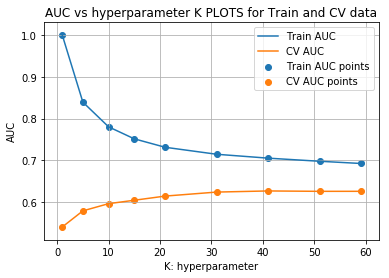

In [110]:
K = [1, 5, 10, 15, 21, 31, 41, 51, 59]
auc_vs_K_plot(bow_train, y_train, bow_cv, y_cv, K)

K = 59 looks good as the gap between CV and Train is less and has high validation AUC.

Test AUC's has to be stored for comparing models at last.

In [111]:
# Dictionary to store Test AUC's
Test_AUCs = {}

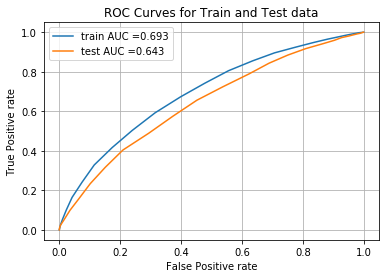


Confusion matrix for Train data with 0.8135593220338984 as threshold:


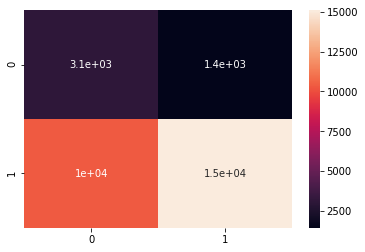


Confusion matrix for Test data with 0.8135593220338984 as threshold:


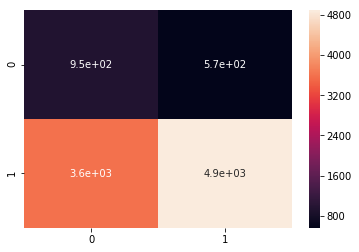

In [133]:
ss, Test_AUCs['bow_brute_AUC'] = ROC_conf_mat(bow_train, y_train, bow_test, y_test, 59)

**We will reuse `auc_vs_K_plot` and `ROC_conf_mat` functions for following data**

### 2.4.2 Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [113]:
# Please write all the code with proper documentation

K = 1 Done!
K = 5 Done!
K = 10 Done!
K = 15 Done!
K = 21 Done!
K = 31 Done!
K = 41 Done!
K = 51 Done!
K = 59 Done!


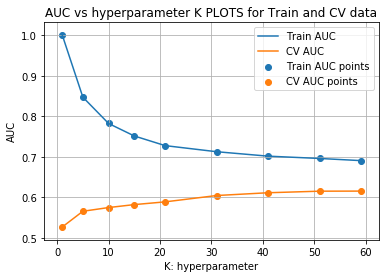

In [114]:
K = [1, 5, 10, 15, 21, 31, 41, 51, 59]
auc_vs_K_plot(tfidf_train, y_train, tfidf_cv, y_cv, K)

Here K = 59 seems to be good

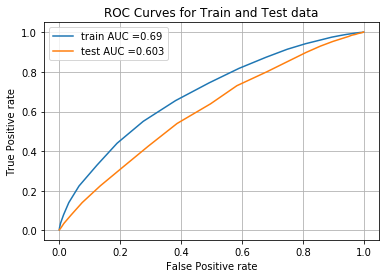


Confusion matrix for Train data with 0.847457627118644 as threshold:


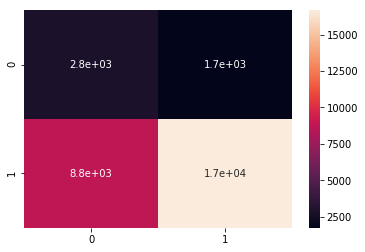


Confusion matrix for Test data with 0.864406779661017 as threshold:


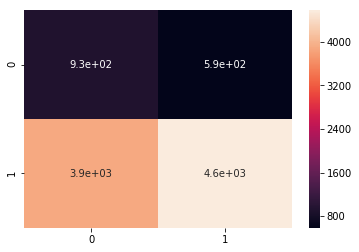

In [115]:
ss, Test_AUCs['tfidf_brute_AUC'] = ROC_conf_mat(tfidf_train, y_train, tfidf_test, y_test, 59)

### 2.4.3 Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [116]:
# Please write all the code with proper documentation

K = 1 Done!
K = 5 Done!
K = 10 Done!
K = 15 Done!
K = 21 Done!
K = 31 Done!
K = 41 Done!
K = 51 Done!
K = 59 Done!


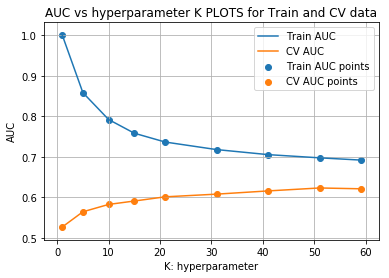

In [117]:
K = [1, 5, 10, 15, 21, 31, 41, 51, 59]
auc_vs_K_plot(avgw2v_train, y_train, avgw2v_cv, y_cv, K)

Taking K = 50 as best hyperparameter.

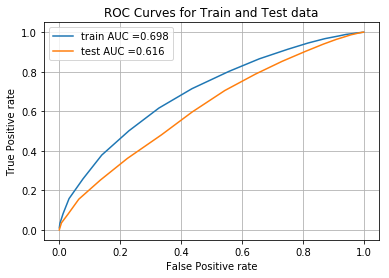


Confusion matrix for Train data with 0.86 as threshold:


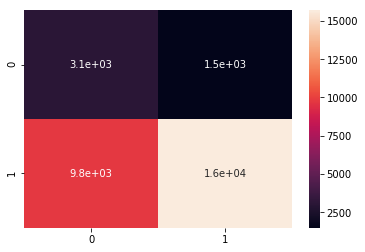


Confusion matrix for Test data with 0.86 as threshold:


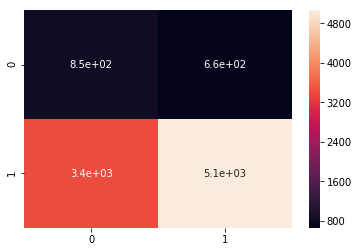

In [130]:
ss, Test_AUCs['avgw2v_brute_AUC'] = ROC_conf_mat(avgw2v_train, y_train, avgw2v_test, y_test, 50)

### 2.4.4 Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [119]:
# Please write all the code with proper documentation

K = 1 Done!
K = 5 Done!
K = 10 Done!
K = 15 Done!
K = 21 Done!
K = 31 Done!
K = 41 Done!
K = 51 Done!
K = 59 Done!


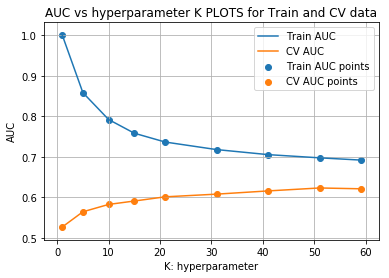

In [120]:
K = [1, 5, 10, 15, 21, 31, 41, 51, 59]
auc_vs_K_plot(avgw2v_train, y_train, avgw2v_cv, y_cv, K)

Here too K = 50 seems good.

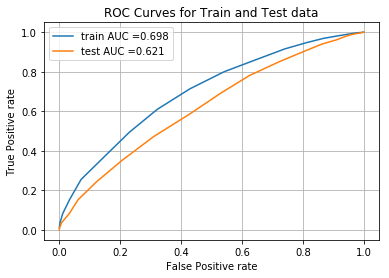


Confusion matrix for Train data with 0.86 as threshold:


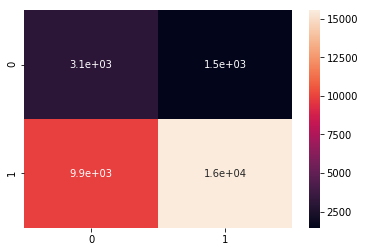


Confusion matrix for Test data with 0.86 as threshold:


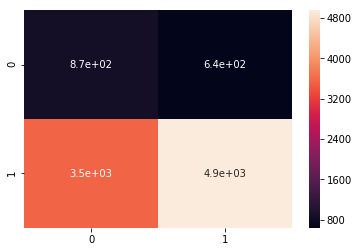

In [131]:
ss, Test_AUCs['tfidfw2v_brute_AUC'] = ROC_conf_mat(tfidfw2v_train, y_train, tfidfw2v_test, y_test, 50)

AUC vs K plots for AvgW2V and TFIDFW2V took so many hours to produce

<h2>2.5 Feature selection with `SelectKBest` </h2>

In [123]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### Doing SelectKBest for TDIDF vectorized data and doing the analysis

In [124]:
warnings.filterwarnings("ignore")
from sklearn.feature_selection import SelectKBest, chi2
kbestmodel = SelectKBest(k=2000)
kbestmodel.fit(tfidf_train, y_train)

tfidf_train_kbest = kbestmodel.transform(tfidf_train)
tfidf_cv_kbest = kbestmodel.transform(tfidf_cv)
tfidf_test_kbest = kbestmodel.transform(tfidf_test)

print(tfidf_train_kbest.shape)
print(tfidf_cv_kbest.shape)
print(tfidf_test_kbest.shape)

(30000, 2000)
(10000, 2000)
(10000, 2000)


K = 1 Done!
K = 5 Done!
K = 10 Done!
K = 15 Done!
K = 21 Done!
K = 31 Done!
K = 41 Done!
K = 51 Done!
K = 59 Done!


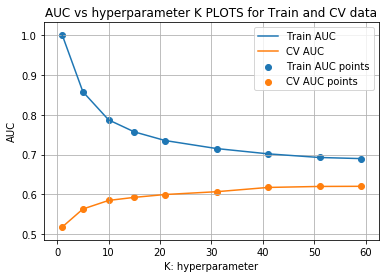

In [125]:
K = [1, 5, 10, 15, 21, 31, 41, 51, 59]
auc_vs_K_plot(tfidf_train_kbest, y_train, tfidf_cv_kbest, y_cv, K)

K = 50 or 59 seems good.

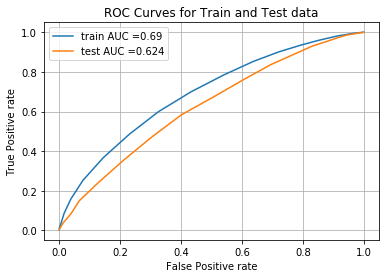


Confusion matrix for Train data with 0.864406779661017 as threshold:


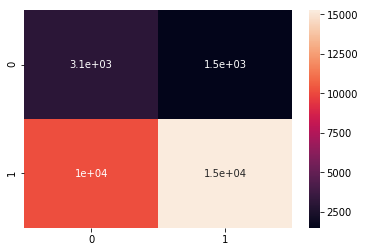


Confusion matrix for Test data with 0.864406779661017 as threshold:


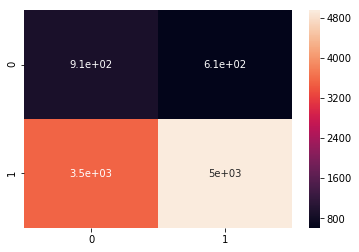

In [126]:
ss, Test_AUCs['tfidf_kbest_AUC'] = ROC_conf_mat(tfidf_train_kbest, y_train, tfidf_test_kbest, y_test, 59)

<h1>3. Conclusions</h1>

In [127]:
# Please compare all your models using Prettytable library

**Here is a table showing all results**

In [134]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Vectorizer', 'Model', 'HyperParameter', 'AUC']
table.add_row(['Bag of Words', 'Brute', '59', Test_AUCs['bow_brute_AUC']])
table.add_row(['TFIDF', 'Brute', '59', Test_AUCs['tfidf_brute_AUC']])
table.add_row(['Average W2V', 'Brute', '50', Test_AUCs['avgw2v_brute_AUC']])
table.add_row(['TFIDF weighted W2V', 'Brute', '50', Test_AUCs['tfidfw2v_brute_AUC']])
table.add_row(['TFIDF', 'Best 2000 cols', '59', Test_AUCs['tfidf_kbest_AUC']])
print(table)

+--------------------+----------------+----------------+--------------------+
|     Vectorizer     |     Model      | HyperParameter |        AUC         |
+--------------------+----------------+----------------+--------------------+
|    Bag of Words    |     Brute      |       59       | 0.6427887302578225 |
|       TFIDF        |     Brute      |       59       | 0.6028543090019078 |
|    Average W2V     |     Brute      |       50       | 0.6160973645979801 |
| TFIDF weighted W2V |     Brute      |       50       | 0.6209552870431415 |
|       TFIDF        | Best 2000 cols |       59       | 0.6242023683806212 |
+--------------------+----------------+----------------+--------------------+


**SUMMARY:**
- **Here Bag of words seems to be doing better than other models.**
- **TFIDF with less columns (2000 columns) doing better than TFIDF with all columns. So considering less columns might improve some of our results.**
- **And the scores that I got are not satisfactory. The gap in AUC vs K plot seems to be reducing with increase in K and didnt reach its minimum.**
- **To increase performance we may have to take all data points (I only considered 50K points due to time issues).**